<a href="https://colab.research.google.com/github/AmulyaMat/EEE-Signal-Classification-ML/blob/main/EEGSignal_CaffeineClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Caffeine’s Influence on Brain Waves with Machine Learning


Objectives:



1.   Extract relevant features of EEG signals from MATLAB files
2.   Perform EDA
3.   Employ Machine Learning to get high classification accuracy of Caffeine Levels



# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier # new model 1
from xgboost import XGBClassifier # new model 2

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt

#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Flatten
#from keras.layers import Dropout
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
#from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Defining functions

In [ ]:
def plot_model_performance (history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epoch = range(len(loss))

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epoch,loss,label='train_loss')
  plt.plot(epoch,val_loss,label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title("Loss graph")

  plt.subplot(1, 2, 2)
  plt.plot(epoch,acc,label='train_acc')
  plt.plot(epoch,val_acc,label='val_acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title("Accuracy graph")

In [ ]:
def plot_confusion_matrix(cm,Label_classes,title):

        cmap = plt.get_cmap('Blues') #cmap=plt.cm.Blues

        plt.figure(figsize=(8,6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title,fontsize=25)

        cbar = plt.colorbar()
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(15)

        tick_marks = np.arange(len(Label_classes))
        plt.xticks(tick_marks, Label_classes, fontsize=20) #rotation=45
        plt.yticks(tick_marks, Label_classes,fontsize=20)

        accuracy = np.trace(cm)/np.sum(cm) #same as using accuracy_score(Label_test, Label_predict) #diagonal summation: tn+tp/total
        precision = cm[1,1]/np.sum(cm,axis=0)[1] #tp/tp+fp
        recall = cm[1,1]/np.sum(cm,axis=1)[1] #tp/tp+fn (sensitivity)
        specificity = cm[0,0]/np.sum(cm,axis=1)[0]  #tn/tn+fp
        f1Score = (2*precision*recall)/(precision + recall)


        threshold = cm.max() / 1.5
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j,i, "{:0.3f}".format(cm[i, j]), #adding text to x,y coordinate
                         horizontalalignment="center",
                         color="white" if cm[i, j] > threshold else "black",fontsize=22)

        plt.tight_layout()
        plt.ylabel('True label',fontsize=22)
        plt.xlabel('Predicted label \n Accuracy= {:.1%}; F1-score= {:.1%}'.format(accuracy, f1Score),fontsize=22)

        plt.show()

In [ ]:
def PCA_transform(train_scaled, test_scaled, n):

  principalComponentsNum = n

  # Perform PCA on scaled data
  pca = PCA(n_components=principalComponentsNum)
  principalComponentNames = ['PC' + str(n) for n in range(1,principalComponentsNum+1)]

  train_scaled_PC = pca.fit_transform(train_scaled)
  train_scaled_PC_df = pd.DataFrame(data = train_scaled_PC, columns = principalComponentNames)

  test_scaled_PC = pca.fit_transform(test_scaled)
  test_scaled_PC_df = pd.DataFrame(data = test_scaled_PC, columns = principalComponentNames)

  return train_scaled_PC_df, test_scaled_PC_df

# Extracting data and splitting into X_train, X_test, y_train, y_test

In [ ]:
filePath = "/content/drive/MyDrive/FinalProject_Dataframe_withscores.xlsx"

In [ ]:
Data_raw = pd.read_excel(filePath, header = 2)
Data_raw

,Instances,Unnamed: 1,Electrode 1,Electrode 2,Electrode 3,Electrode 4,Electrode 5,Electrode 6,Electrode 1.1,Electrode 2.1,...,Electrode 3.2,Electrode 4.2,Electrode 5.2,Electrode 6.2,Mean HR,HRV,Score,Norm Score,Classification,Unnamed: 25
0,2023-11-07,N-Back 1,3.5536,4.2227,0.4238,1.8395,1.1981,2.1099,2.5290,1.6512,...,0.5040,1.4885,0.6312,1.3244,89.2961,40.3034,3917.00,0.966266,0.0,Start of P1
1,NaT,N-Back 2,3.5902,1.6762,0.4594,1.6490,0.7911,0.7743,3.4970,1.6774,...,0.4254,1.5174,0.6428,0.7628,81.0210,41.0370,2816.00,0.694665,0.0,NaN
2,NaT,N-Back 3,4.2705,1.9126,0.3738,1.8058,0.6898,0.6034,4.0043,1.8427,...,0.3676,1.6447,0.6008,0.6046,81.4960,37.5704,2623.00,0.647055,0.0,NaN
3,NaT,Digit 1,5.7641,2.4892,0.4226,2.1487,0.7436,0.6334,5.3574,2.3824,...,0.4032,2.0614,0.6789,0.5345,86.2896,40.1221,1.00,1.131631,0.0,NaN
4,NaT,Digit 2,5.9589,2.5284,0.3932,2.1370,0.7080,0.4088,5.8986,2.5083,...,0.4064,2.0857,0.6779,0.4375,85.7409,49.1163,1.00,1.131631,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,NaT,Digit 3,2.3050,5.9601,7.1783,0.0615,2.0588,3.6681,2.0692,5.8791,...,7.4988,0.0459,3.2029,3.6303,63.5137,5824.0000,0.75,0.852632,1.0,NaN
118,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Max,123.3998,5824.0000,NaN,NaN,NaN,NaN


In [ ]:
Data_raw2 = Data_raw.iloc[:-4, :-1]
Data_raw2

In [ ]:
# @title
Data_raw1 = Data_raw.iloc[:, 2:-1]
Data = Data_raw1.drop(columns=['Score', 'Norm Score'])
Data

,Electrode 1,Electrode 2,Electrode 3,Electrode 4,Electrode 5,Electrode 6,Electrode 1.1,Electrode 2.1,Electrode 3.1,Electrode 4.1,...,Electrode 6.1,Electrode 1.2,Electrode 2.2,Electrode 3.2,Electrode 4.2,Electrode 5.2,Electrode 6.2,Mean HR,HRV,Classification
0,3.5536,4.2227,0.4238,1.8395,1.1981,2.1099,2.5290,1.6512,0.4830,1.5320,...,1.5056,2.3669,1.1356,0.5040,1.4885,0.6312,1.3244,89.2961,40.3034,0
1,3.5902,1.6762,0.4594,1.6490,0.7911,0.7743,3.4970,1.6774,0.4239,1.5201,...,0.7726,3.4885,1.6878,0.4254,1.5174,0.6428,0.7628,81.0210,41.0370,0
2,4.2705,1.9126,0.3738,1.8058,0.6898,0.6034,4.0043,1.8427,0.3745,1.6327,...,0.6306,4.0049,1.8600,0.3676,1.6447,0.6008,0.6046,81.4960,37.5704,0
3,5.7641,2.4892,0.4226,2.1487,0.7436,0.6334,5.3574,2.3824,0.4155,2.0282,...,0.5782,5.3577,2.4081,0.4032,2.0614,0.6789,0.5345,86.2896,40.1221,0
4,5.9589,2.5284,0.3932,2.1370,0.7080,0.4088,5.8986,2.5083,0.3937,2.0961,...,0.4301,5.9055,2.5052,0.4064,2.0857,0.6779,0.4375,85.7409,49.1163,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,4.4219,5.9668,4.8666,0.1229,0.7346,3.0269,2.1472,5.7685,5.0228,0.0192,...,2.9163,1.5824,5.7418,5.0780,0.0177,1.7921,2.9096,75.7167,26.2906,1
104,1.2682,5.8470,5.0901,0.0738,0.8226,3.1423,1.1407,5.7767,5.3188,0.0151,...,3.0665,1.1401,5.7571,5.3622,0.0132,1.8993,3.0583,78.3080,160.7241,1
105,1.7100,6.7921,7.0485,0.0244,1.5681,3.5082,1.5978,6.8820,7.4933,0.0299,...,3.6391,1.6008,6.8596,7.5393,0.0316,2.8298,3.6363,62.0698,3140.8000,1
106,1.6978,6.3895,7.1113,0.0189,1.9257,3.6046,1.7026,6.3258,7.4197,0.0344,...,3.6129,1.7035,6.2929,7.4709,0.0422,3.1577,3.6092,81.0300,27.1429,1


In [ ]:
X_data = Data_raw2.iloc[:, 2:-1]
y_data = Data_raw2.iloc[:, -1]

In [ ]:
X_data.dtypes

Electrode 1      float64
Electrode 2      float64
Electrode 3      float64
Electrode 4      float64
Electrode 5      float64
Electrode 6      float64
Electrode 1.1    float64
Electrode 2.1    float64
Electrode 3.1    float64
Electrode 4.1    float64
Electrode 5.1    float64
Electrode 6.1    float64
Electrode 1.2    float64
Electrode 2.2    float64
Electrode 3.2    float64
Electrode 4.2    float64
Electrode 5.2    float64
Electrode 6.2     object
Mean HR          float64
HRV              float64
Score            float64
Norm Score       float64
dtype: object

In [ ]:
y_data.dtypes

dtype('float64')

In [ ]:
X_data

,Electrode 1,Electrode 2,Electrode 3,Electrode 4,Electrode 5,Electrode 6,Electrode 1.1,Electrode 2.1,Electrode 3.1,Electrode 4.1,...,Electrode 1.2,Electrode 2.2,Electrode 3.2,Electrode 4.2,Electrode 5.2,Electrode 6.2,Mean HR,HRV,Score,Norm Score
0,3.5536,4.2227,0.4238,1.8395,1.1981,2.1099,2.5290,1.6512,0.4830,1.5320,...,2.3669,1.1356,0.5040,1.4885,0.6312,1.3244,89.2961,40.3034,3917.000000,0.966266
1,3.5902,1.6762,0.4594,1.6490,0.7911,0.7743,3.4970,1.6774,0.4239,1.5201,...,3.4885,1.6878,0.4254,1.5174,0.6428,0.7628,81.0210,41.0370,2816.000000,0.694665
2,4.2705,1.9126,0.3738,1.8058,0.6898,0.6034,4.0043,1.8427,0.3745,1.6327,...,4.0049,1.8600,0.3676,1.6447,0.6008,0.6046,81.4960,37.5704,2623.000000,0.647055
3,5.7641,2.4892,0.4226,2.1487,0.7436,0.6334,5.3574,2.3824,0.4155,2.0282,...,5.3577,2.4081,0.4032,2.0614,0.6789,0.5345,86.2896,40.1221,1.000000,1.131631
4,5.9589,2.5284,0.3932,2.1370,0.7080,0.4088,5.8986,2.5083,0.3937,2.0961,...,5.9055,2.5052,0.4064,2.0857,0.6779,0.4375,85.7409,49.1163,1.000000,1.131631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,4.4219,5.9668,4.8666,0.1229,0.7346,3.0269,2.1472,5.7685,5.0228,0.0192,...,1.5824,5.7418,5.0780,0.0177,1.7921,2.9096,75.7167,26.2906,2686.000000,1.091278
114,1.2682,5.8470,5.0901,0.0738,0.8226,3.1423,1.1407,5.7767,5.3188,0.0151,...,1.1401,5.7571,5.3622,0.0132,1.8993,3.0583,78.3080,160.7241,2648.000000,1.075840
115,1.7100,6.7921,7.0485,0.0244,1.5681,3.5082,1.5978,6.8820,7.4933,0.0299,...,1.6008,6.8596,7.5393,0.0316,2.8298,3.6363,62.0698,3140.8000,1.000000,1.136842
116,1.6978,6.3895,7.1113,0.0189,1.9257,3.6046,1.7026,6.3258,7.4197,0.0344,...,1.7035,6.2929,7.4709,0.0422,3.1577,3.6092,81.0300,27.1429,0.888889,1.010526


In [ ]:
y_data

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
113    1.0
114    1.0
115    1.0
116    1.0
117    1.0
Name: Classification, Length: 118, dtype: float64

In [ ]:
y_data.unique()

array([0., 1., 2.])

# Scaling data

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [ ]:
# 2. Standardization using Z-score scaling (mean=0, std=1)
scaler_standard = StandardScaler()

X_train_scaled = scaler_standard.fit_transform(X_train)
X_test_scaled = scaler_standard.fit_transform(X_test)

In [ ]:
X_train_scaled.shape

(94, 22)

In [ ]:
X_test_scaled.shape

(24, 22)

In [ ]:
y_train.shape

(94,)

In [ ]:
from scipy import stats


# Calculate z-scores for each column
z_scores = stats.zscore(X_data)

# Set a threshold for outlier detection (e.g., 3 standard deviations)
threshold = 3

# Find indices of outliers
outlier_indices = (np.abs(z_scores) > threshold).any(axis=1)

# Display the rows with outliers
outliers = X_data[outlier_indices]
print("Outliers:")
print(outliers)

Outliers:
     Electrode 1  Electrode 2  Electrode 3  Electrode 4  Electrode 5  \
77       41.3628      30.4894      28.6189      34.8456      24.6702   
78       41.4999      31.2060      29.1425      35.5116      25.2483   
79       42.2805      32.4155      29.9180      36.8212      26.3922   
80       43.4556      33.2449      30.8783      38.0922      27.3142   
81       44.2254      34.2008      31.3313      38.8946      27.9444   
87       30.5071      17.4042      51.7490       3.8597      53.2871   
88       28.9095      16.6371      50.1523       3.6845      52.7890   
89       32.7520      20.3552      54.5472       7.3559      56.4672   
97       21.3330      18.9363      16.9915       4.7295      13.6155   
105       1.7100       6.7921       7.0485       0.0244       1.5681   
107       2.3050       5.9601       7.1783       0.0615       2.0588   

     Electrode 6  Electrode 1.1  Electrode 2.1  Electrode 3.1  Electrode 4.1  \
77       20.4767        41.1119        31.550

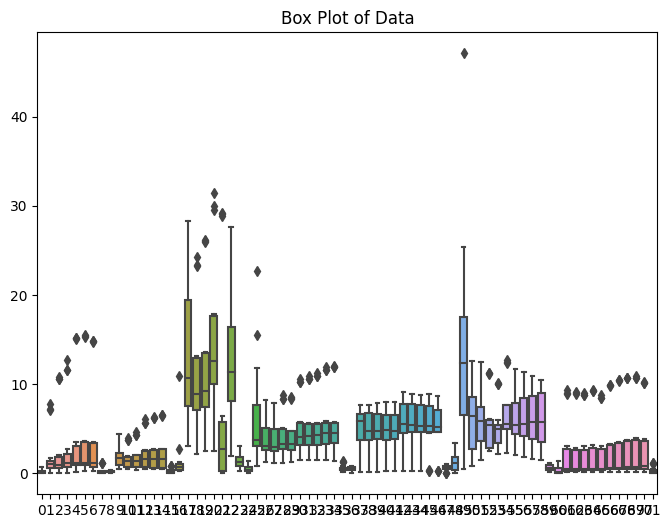

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(data=X)
plt.title("Box Plot of Data")
plt.show()

In [ ]:
from functools import reduce

def column_add(a, b):
    return a + b

def find_outliers(df):
    # Identifying the numerical columns in a pandas DataFrame
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:
        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1: First Quartile, Q3: Third Quartile
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        # IQR: Interquartile Range
        IQR = Q3 - Q1

        # Selecting the data, with -1.5*IQR to +1.5*IQR, where param = 1.5 default value
        less_Q1 = Q1 - 1.5 * IQR
        more_Q3 = Q3 + 1.5 * IQR

        isOutlierCol = 'is_outlier_{}'.format(column)

        df[isOutlierCol] = ((df[column] > more_Q3) | (df[column] < less_Q1)).astype(int)

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new column "total_outliers", to see the total number of outliers
    df['total_outliers'] = df[selected_columns].sum(axis=1)

    # Dropping the extra columns created above, just to create a nice DataFrame without extra columns
    df = df.drop(columns=[column for column in df.columns if column.startswith("is_outlier")])

    return df


In [ ]:
X_data_with_outlier_handling = find_outliers(X_data)

In [ ]:
num_unique_values = X_data_with_outlier_handling['total_outliers'].value_counts()

In [ ]:
num_unique_values

0     73
1      9
6      9
3      7
2      4
10     2
9      1
12     1
13     1
7      1
Name: total_outliers, dtype: int64

#Model 1: Random Forest

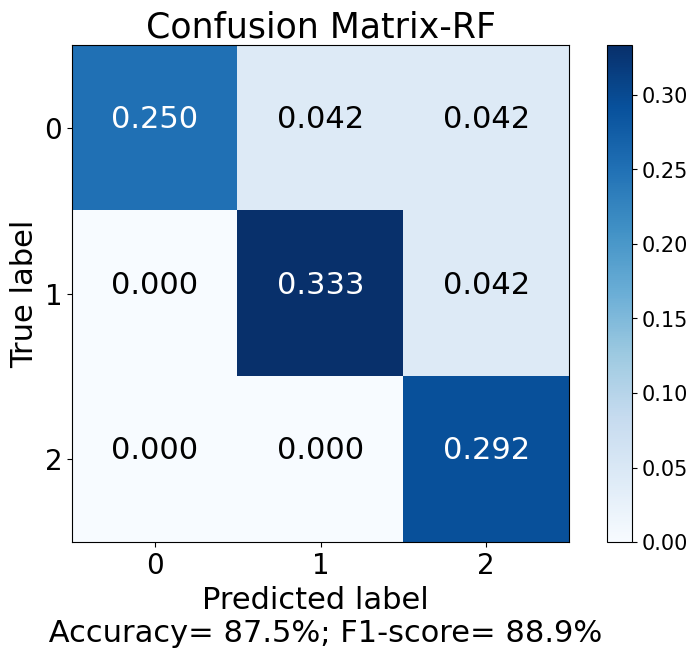

In [ ]:
#RF - new model 1
rf=RandomForestClassifier(n_estimators=1000, random_state = 42)
rf.fit(X_train_scaled,y_train)
PredictLabel_RF= rf.predict(X_test_scaled)
cmRF = confusion_matrix(y_test, PredictLabel_RF, normalize='all')

plot_confusion_matrix(cmRF,Label_classes=['0', '1', '2'],title='Confusion Matrix-RF')


# Feature importance
# feat_im = rf.feature_importances_ # feature importance

# Visualize feature importance
# colnames = df.columns.values
# features_names = colnames[0:-1] # exclude last column header because it's the outcome label
# fig3 = plt.figure(figsize=(10,7))
# plt.barh(features_names, rf.feature_importances_)
# plt.show()


#Model 2: XGBoost

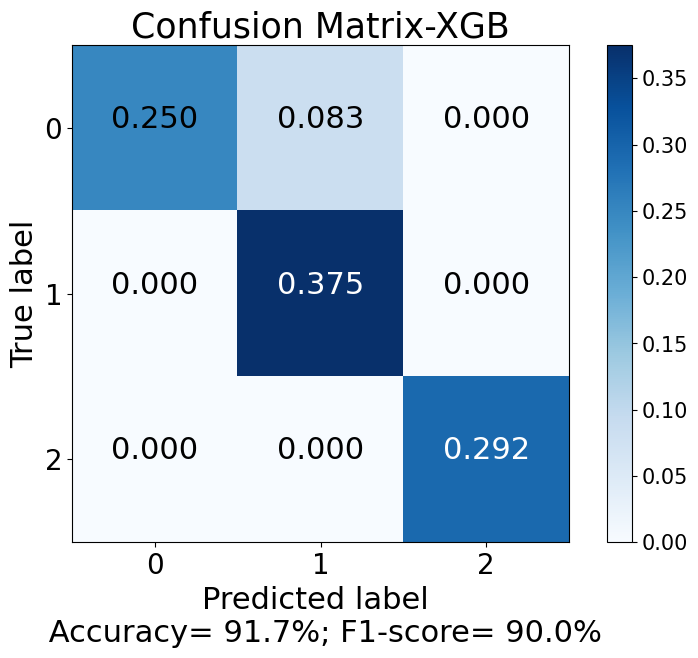

In [ ]:
#XG BOOST - new model 2
XGB = XGBClassifier()
XGB.fit(X_train_scaled, y_train.ravel())

PredictLabel_XGB = XGB.predict(X_test_scaled)

cmXGB = confusion_matrix(y_test.ravel(), PredictLabel_XGB, normalize='all')
plot_confusion_matrix(cmXGB,Label_classes=['0', '1', '2'],title='Confusion Matrix-XGB')


In [ ]:
# Try with PCA
principalComponentsNum = 3

# Perform PCA on scaled data
pca = PCA(n_components=principalComponentsNum)
principalComponentNames = ['PC' + str(n) for n in range(1,principalComponentsNum+1)]

X_train_scaled_PC = pca.fit_transform(X_train_scaled)
X_train_scaled_PC_df = pd.DataFrame(data = X_train_scaled_PC, columns = principalComponentNames)
display(X_train_scaled_PC_df) # a dataframe with top 5 variables (PC1 - 5)


,PC1,PC2,PC3
0,0.844472,1.971686,0.975470
1,-2.106023,-0.099806,0.103903
2,-2.017415,-0.146774,0.059465
3,-1.969641,-0.074748,0.582702
4,-3.093570,-1.042434,0.779628
...,...,...,...
81,4.586472,3.427292,0.987962
82,-2.522817,-0.334809,-0.110315
83,0.167115,0.805019,-0.851859
84,-2.990268,-1.004721,0.576243


In [ ]:
X_test_scaled_PC = pca.fit_transform(X_test_scaled)
X_test_scaled_PC_df = pd.DataFrame(data = X_test_scaled_PC, columns = principalComponentNames)

In [ ]:
X_train_scaled_PC_df, X_test_scaled_PC_df = PCA_transform(X_train_scaled, X_test_scaled, 3)

# Trying Model 1 and 2 with PCA transformation on X_train and X_test

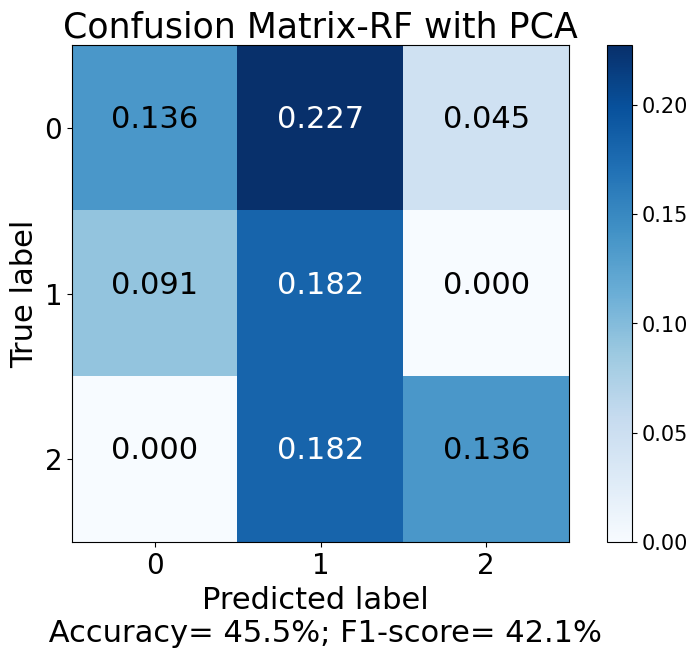

In [ ]:
# Try RF with PCA
rf.fit(X_train_scaled_PC_df,y_train)
PredictLabel_RF_PCA= rf.predict(X_test_scaled_PC_df)
cmRF_PCA = confusion_matrix(y_test, PredictLabel_RF_PCA, normalize='all')

plot_confusion_matrix(cmRF_PCA,Label_classes=['0', '1', '2'],title='Confusion Matrix-RF with PCA')

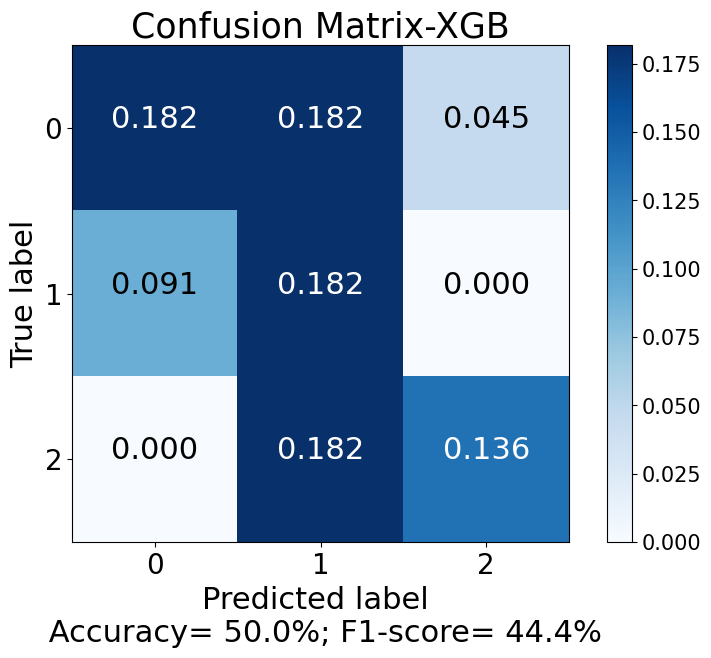

In [ ]:
# Try XGB with PCA
XGB.fit(X_train_scaled_PC_df,y_train)

PredictLabel_XGB_PCA = XGB.predict(X_test_scaled_PC_df)

cmXGB_PCA = confusion_matrix(y_test.ravel(), PredictLabel_XGB_PCA, normalize='all')
plot_confusion_matrix(cmXGB_PCA,Label_classes=['0', '1', '2'],title='Confusion Matrix-XGB')

# Plotting RF and XGB accuracies with vaarying PCA n_components

Text(0, 0.5, 'RF accuracies')

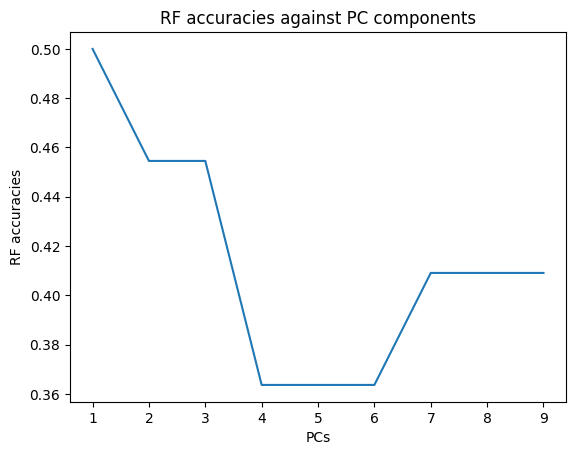

In [ ]:
# to record best PCA components value
accuracies = []
for n in range(1, 10):

  X_train_scaled_PC_df, X_test_scaled_PC_df = PCA_transform(X_train_scaled, X_test_scaled, n)

  rf.fit(X_train_scaled_PC_df,y_train)
  PredictLabel_RF_PCA= rf.predict(X_test_scaled_PC_df)

  accuracies.append(accuracy_score(y_test, PredictLabel_RF_PCA))

plt.plot(range(1,10), accuracies)
plt.title("RF accuracies against PC components")
plt.xlabel("PCs")
plt.ylabel("RF accuracies")


Text(0, 0.5, 'XGB accuracies')

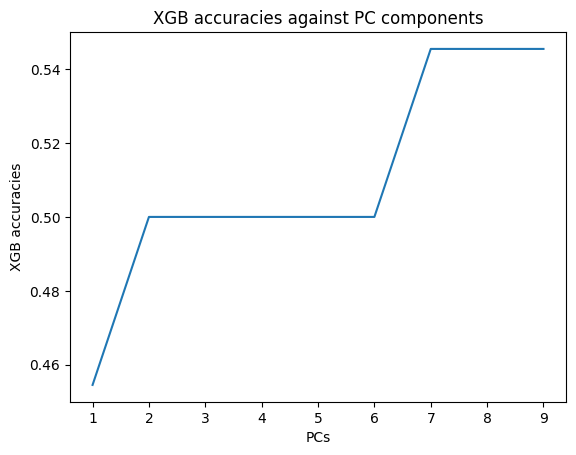

In [ ]:
XGB_accuracies = []
for n in range(1, 10):

  X_train_scaled_PC_df, X_test_scaled_PC_df = PCA_transform(X_train_scaled, X_test_scaled, n)

  XGB.fit(X_train_scaled_PC_df,y_train)
  PredictLabel_XGB_PCA= XGB.predict(X_test_scaled_PC_df)

  XGB_accuracies.append(accuracy_score(y_test, PredictLabel_XGB_PCA))

plt.plot(range(1,10), XGB_accuracies)
plt.title("XGB accuracies against PC components")
plt.xlabel("PCs")
plt.ylabel("XGB accuracies")

# Hyperparameter tuning RF AND XGB model

In [ ]:
# HYPER PARAMETER TUNING

from sklearn.model_selection import GridSearchCV

# Create a RandomForestClassifier instance
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 500, 1000],  # you can add more values
    'max_depth': [None, 10, 20, 30],  # you can add more values
    'min_samples_split': [2, 5, 10],  # you can add more values
    'min_samples_leaf': [1, 2, 4]  # you can add more values
}

In [ ]:
# Create a GridSearchCV instance
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=
# Fit the GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Use the best model to make predictions on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

Accuracy on Test Set: 0.8636363636363636


In [ ]:
rf_try=RandomForestClassifier(n_estimators=100, random_state = 42, max_depth = 10, min_samples_leaf= 1, min_samples_split= 2)
rf_try.fit(X_train_scaled,y_train)
PredictLabel_RFtry= rf_try.predict(X_test_scaled)

accuracy = accuracy_score(y_test, PredictLabel_RFtry)

In [ ]:
print(accuracy)

0.8636363636363636


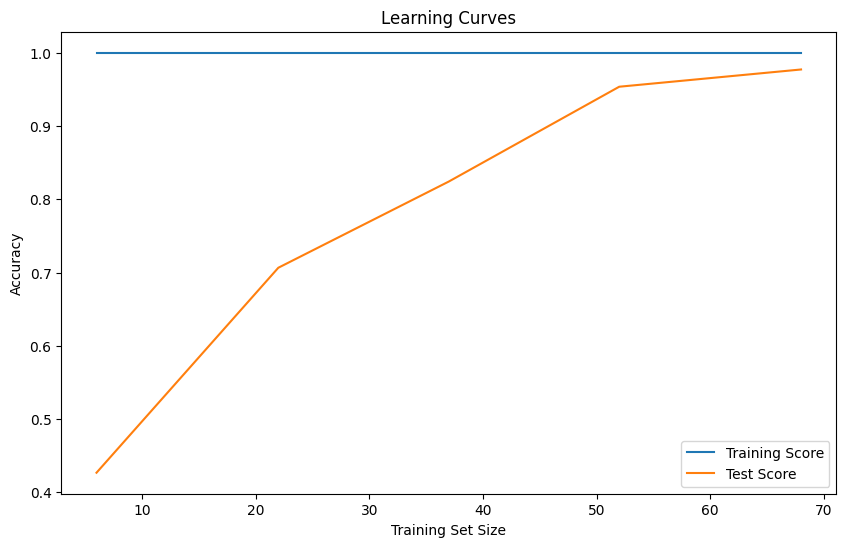

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_try, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [ ]:
# learning curve for RF
#train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train.ravel(), cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), verbose = 1)
train_sizes, train_scores, test_scores = learning_curve(rf, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), verbose = 1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve for RF model")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Assume y_train is a 1D array of class labels with 'DIIF' and 'cell' as the categories
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
t_train_onehot = to_categorical(y_train_encoded)
t_test_onehot = to_categorical(y_test_encoded)

# Trying with MATLAB

In [ ]:
pip install scipy

In [ ]:
# @title
from scipy.io import loadmat

#mat_contents = loadmat('Maddie_Preprocessed.mat')

maddie_contents = loadmat('/content/drive/MyDrive/Maddie_Preprocessed.mat')
martin_contents = loadmat('/content/drive/MyDrive/Martin_Preprocessed.mat')
annabel_contents= loadmat('/content/drive/MyDrive/Annabel_Preprocessed.mat')

In [ ]:
# @title
struct_data = mat_contents['trialData']
field_data = struct_data['waveMat'][0, 0]

In [ ]:
# @title
field_data

array([[0.11209141, 0.03566209, 0.01141502],
       [0.32682313, 0.17483039, 0.14623618],
       [0.68728555, 0.57063787, 0.55757115],
       [0.34539014, 0.15403777, 0.1071211 ],
       [0.10405467, 0.03906372, 0.01810926],
       [0.24775193, 0.03777604, 0.00270687]])

In [ ]:
# @title
print(maddie_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'trialData'])


In [ ]:
# @title
array1 = maddie_contents['trialData']

In [ ]:
# @title
df = pd.DataFrame(array1.flatten())

In [ ]:
# @title
df

,Type,CaffIntake,Day,Time,waveMat,HR,EEGSignal
0,[Prebase],[[1]],[2023-11-03],[09-39-33],"[[0.11209141377627405, 0.0356620862135102, 0.0...",[],"[[[[[(array([[-59.64016752],\n [-51.79..."
1,[NBack],[[1]],[2023-11-03],[10-15-29],"[[1.7630207702351819, 1.2530119850613757, 0.99...",[],"[[[[[(array([[ 1.70057575],\n [ 5.2603..."
2,[NBack],[[1]],[2023-11-03],[10-19-06],"[[2.0464026287865176, 1.7411524640678127, 1.78...",[],"[[[[[(array([[38.42035851],\n [41.9371..."
3,[NBack],[[1]],[2023-11-03],[10-22-40],"[[2.7082310981062543, 2.181162327071589, 2.170...",[],"[[[[[(array([[ 13.25933562],\n [ 20.95..."
4,[Digit],[[1]],[2023-11-03],[10-27-07],"[[3.4785333675282843, 3.1070216482107855, 3.12...",[],"[[[[[(array([[17.19468714],\n [22.2622..."
...,...,...,...,...,...,...,...
67,[Digit],[[2]],[2023-12-01],[10-06-44],"[[10.501578903754735, 10.39190499707997, 10.46...","[[76.92307692307692], [76.14213197969544], [78...","[[[[[(array([[10.40610268],\n [ 7.6763..."
68,[Digit],[[2]],[2023-12-01],[10-09-11],"[[10.648466236607698, 10.661897846725347, 10.7...","[[78.94736842105264], [81.52173913043475], [81...","[[[[[(array([[-24.22745559],\n [-24.19..."
69,[Digit],[[2]],[2023-12-01],[10-11-28],"[[10.956336141495326, 10.71228153281473, 10.72...","[[84.26966292134833], [85.7142857142857], [88....","[[[[[(array([[26.30995167],\n [27.7244..."
70,[Digit],[[2]],[2023-12-01],[10-13-41],"[[10.277458600065772, 10.181869069888533, 10.1...","[[85.71428571428572], [85.7142857142857], [87....","[[[[[(array([[-18.01684927],\n [-21.02..."


In [ ]:
from scipy.io import loadmat

# Load data
maddie_contents = loadmat('/content/drive/MyDrive/Maddie_Preprocessed.mat')
martin_contents = loadmat('/content/drive/MyDrive/Martin_Preprocessed.mat')
annabel_contents = loadmat('/content/drive/MyDrive/Annabel_Preprocessed.mat')

# Extract 'trialData' for each person
maddie_data = maddie_contents['trialData']
martin_data = martin_contents['trialData']
annabel_data = annabel_contents['trialData']

df_maddie = pd.DataFrame(maddie_data.flatten())
df_martin = pd.DataFrame(martin_data.flatten())
df_annabel = pd.DataFrame(annabel_data.flatten())

# Concatenate DataFrames along rows
df_combined = pd.concat([df_maddie, df_martin, df_annabel], axis=0)


In [ ]:
df_combinedMM = pd.concat([df_maddie, df_martin], axis=0)


In [ ]:
df_combinedMM

,Type,CaffIntake,Day,Time,waveMat,HR,EEGSignal,waveMat_DWT
0,[NBack],[[1]],[2023-11-03],[10-15-29],"[[1.6509293564589078, 1.2173498988478655, 0.98...",[],"[[[[[(array([[ 1.70057575],\n [ 5.2603...","[[0.9500327033298426, 0.2219569119240289, 0.00..."
1,[NBack],[[1]],[2023-11-03],[10-19-06],"[[1.9343112150102435, 1.7054903778543025, 1.77...",[],"[[[[[(array([[38.42035851],\n [41.9371...","[[0.2514191300080809, 0.014014565849422699, 0...."
2,[NBack],[[1]],[2023-11-03],[10-22-40],"[[2.59613968432998, 2.1455002408580786, 2.1593...",[],"[[[[[(array([[ 13.25933562],\n [ 20.95...","[[0.2620946864414002, 0.033852473881469045, 0...."
3,[Digit],[[1]],[2023-11-03],[10-27-07],"[[3.3664419537520103, 3.071359561997275, 3.111...",[],"[[[[[(array([[17.19468714],\n [22.2622...","[[0.03922295604004189, -0.006723351142051515, ..."
4,[Digit],[[1]],[2023-11-03],[10-29-34],"[[3.486426103436353, 3.413930986419439, 3.4717...",[],"[[[[[(array([[ -8.71270653],\n [-10.12...","[[0.07725637368468852, -0.0067339201004773044,..."
...,...,...,...,...,...,...,...,...
55,[Digit],[[2]],[2023-12-08],[10-42-06],"[[12.455598392255467, 14.549046317212325, 14.4...","[[83.33333333333334], [80.64516129032259], [80...","[[[[[(array([[-2.22057834],\n [-3.9063...","[[-1.9058945116938677, -0.3834201456954798, -0..."
56,[Digit],[[2]],[2023-12-08],[10-44-21],"[[11.279842806942856, 13.904607103777755, 14.6...","[[84.7457627118644], [81.08108108108108], [81....","[[[[[(array([[-25.36800999],\n [-26.37...","[[-1.8780404447104304, -0.3821867491503106, -0..."
57,[Digit],[[2]],[2023-12-08],[10-46-24],"[[13.058938806380741, 14.831765188338817, 14.6...","[[77.31958762886599], [81.52173913043475], [80...","[[[[[(array([[-3.76764103],\n [ 2.7916...","[[-1.8959858798470255, -0.3825973197894996, -0..."
58,[Digit],[[2]],[2023-12-08],[10-48-29],"[[12.278493111141731, 14.394621662925266, 14.7...","[[90.90909090909092], [104.16666666666666], [9...","[[[[[(array([[-4.03397749],\n [-1.0794...","[[-1.8882008746649377, -0.38256346948683145, -..."


In [ ]:
df_combined

,Type,CaffIntake,Day,Time,waveMat,HR,EEGSignal,waveMat_DWT
0,[NBack],[[1]],[2023-11-03],[10-15-29],"[[1.6509293564589078, 1.2173498988478655, 0.98...",[],"[[[[[(array([[ 1.70057575],\n [ 5.2603...","[[0.9500327033298426, 0.2219569119240289, 0.00..."
1,[NBack],[[1]],[2023-11-03],[10-19-06],"[[1.9343112150102435, 1.7054903778543025, 1.77...",[],"[[[[[(array([[38.42035851],\n [41.9371...","[[0.2514191300080809, 0.014014565849422699, 0...."
2,[NBack],[[1]],[2023-11-03],[10-22-40],"[[2.59613968432998, 2.1455002408580786, 2.1593...",[],"[[[[[(array([[ 13.25933562],\n [ 20.95...","[[0.2620946864414002, 0.033852473881469045, 0...."
3,[Digit],[[1]],[2023-11-03],[10-27-07],"[[3.3664419537520103, 3.071359561997275, 3.111...",[],"[[[[[(array([[17.19468714],\n [22.2622...","[[0.03922295604004189, -0.006723351142051515, ..."
4,[Digit],[[1]],[2023-11-03],[10-29-34],"[[3.486426103436353, 3.413930986419439, 3.4717...",[],"[[[[[(array([[ -8.71270653],\n [-10.12...","[[0.07725637368468852, -0.0067339201004773044,..."
...,...,...,...,...,...,...,...,...
1,[NBack],[[0]],[2023-11-14],[10-59-36],"[[4.421856348693941, 2.1472178314415498, 1.582...","[[72.463768115942], [75.00000000000001], [80.2...","[[[[[(array([[ 32.76918564],\n [ 31.61...","[[0.18605898929741627, 0.012283096954262647, 0..."
2,[NBack],[[0]],[2023-11-14],[11-02-08],"[[1.268180778819748, 1.1406877327611782, 1.140...","[[72.463768115942], [66.07929515418499], [68.8...","[[[[[(array([[-3.32599897],\n [-2.5829...","[[0.10408423438451843, 0.011041688139637252, 0..."
3,[Digit],[[0]],[2023-11-14],[11-07-10],"[[1.7099589886604456, 1.597817764147293, 1.600...","[[72.81553398058239], [73.17073170731705], [79...","[[[[[(array([[-0.27836727],\n [ 3.7989...","[[0.035264589075468644, 0.003600475104793893, ..."
4,[Digit],[[0]],[2023-11-14],[11-09-54],"[[1.6977297283065436, 1.7025596333115782, 1.70...","[[78.9473684210521], [78.534031413613], [77.31...","[[[[[(array([[ 6.77473471],\n [10.0297...","[[0.0489112165558729, 0.013944774858709595, 0...."


In [ ]:
#X = df_combined['waveMat']
X = df_combinedMM['waveMat']
X

0     [[1.6509293564589078, 1.2173498988478655, 0.98...
1     [[1.9343112150102435, 1.7054903778543025, 1.77...
2     [[2.59613968432998, 2.1455002408580786, 2.1593...
3     [[3.3664419537520103, 3.071359561997275, 3.111...
4     [[3.486426103436353, 3.413930986419439, 3.4717...
                            ...                        
55    [[12.455598392255467, 14.549046317212325, 14.4...
56    [[11.279842806942856, 13.904607103777755, 14.6...
57    [[13.058938806380741, 14.831765188338817, 14.6...
58    [[12.278493111141731, 14.394621662925266, 14.7...
59    [[12.738206076017157, 14.681611375753414, 15.0...
Name: waveMat, Length: 118, dtype: object

In [ ]:
# Flatten each 2D array within the Series
X_flattened = X.apply(lambda x: x.flatten())

# Convert the resulting Series of flattened arrays to a NumPy array
X_flattened_array = np.vstack(X_flattened)

print(X_flattened_array.shape)

X_flattened_array

(118, 18)


array([[ 1.65092936,  1.2173499 ,  0.98799482, ...,  0.84655901,
         0.57482667,  0.54158342],
       [ 1.93431122,  1.70549038,  1.77376417, ...,  0.74360238,
         0.68149261,  0.83191442],
       [ 2.59613968,  2.14550024,  2.15933014, ...,  1.5161471 ,
         1.09480335,  1.12869016],
       ...,
       [13.05893881, 14.83176519, 14.6706765 , ..., 21.18887714,
        20.19458108, 19.51854612],
       [12.27849311, 14.39462166, 14.74175736, ..., 21.06415603,
        20.06689557, 19.48640451],
       [12.73820608, 14.68161138, 15.01843172, ..., 21.73143653,
        20.70501558, 20.04106763]])

In [ ]:
#y = df_combined['CaffIntake']
y = df_combinedMM['CaffIntake']
y

0     [[1]]
1     [[1]]
2     [[1]]
3     [[1]]
4     [[1]]
      ...  
55    [[2]]
56    [[2]]
57    [[2]]
58    [[2]]
59    [[2]]
Name: CaffIntake, Length: 118, dtype: object

In [ ]:
# Flatten each 2D array within the Series
y_flattened = y.apply(lambda y: y.flatten())

# Convert the resulting Series of flattened arrays to a NumPy array
y_flattened_array = np.vstack(y_flattened)

y_flattened_array.shape

(118, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_flattened_array, y_flattened_array, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(94, 18)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 2. Standardization using Z-score scaling (mean=0, std=1)
scaler_standard = StandardScaler()

#X_train = X_train.reshape(-1, 2)

X_train_scaled = scaler_standard.fit_transform(X_train)
X_test_scaled = scaler_standard.fit_transform(X_test)

<ipython-input-135-a95a0e5be726>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled,y_train)


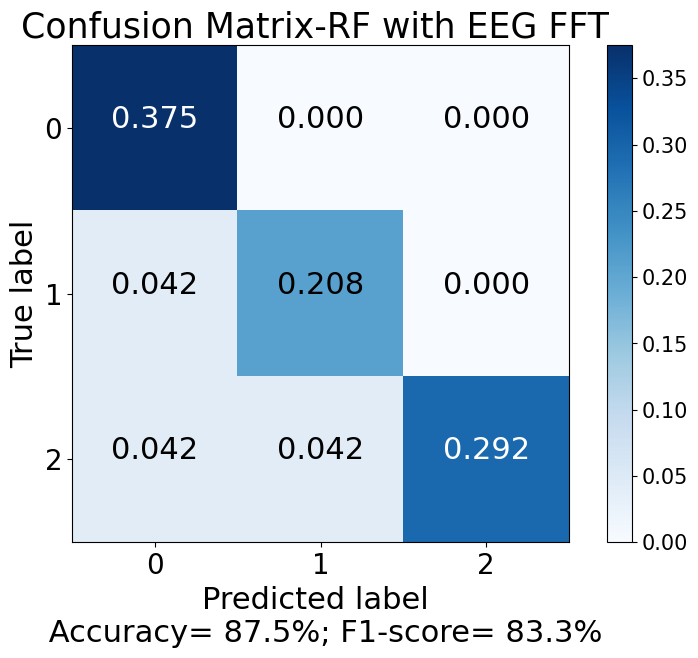

In [ ]:
#RF - new model 1
rf=RandomForestClassifier(n_estimators=1000, random_state = 42)
rf.fit(X_train_scaled,y_train)
PredictLabel_RF= rf.predict(X_test_scaled)
cmRF = confusion_matrix(y_test, PredictLabel_RF, normalize='all')

plot_confusion_matrix(cmRF,Label_classes=['0', '1', '2'],title='Confusion Matrix-RF with EEG FFT ')


In [ ]:
rf.predict(X_test_scaled)

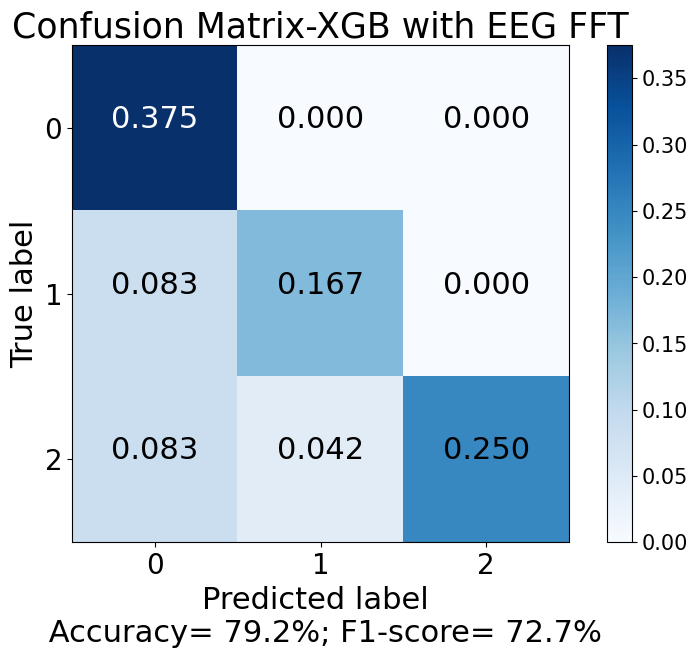

In [ ]:
#XG BOOST - new model 2
XGB = XGBClassifier()
XGB.fit(X_train_scaled, y_train.ravel())

PredictLabel_XGB = XGB.predict(X_test_scaled)

cmXGB = confusion_matrix(y_test.ravel(), PredictLabel_XGB, normalize='all')
plot_confusion_matrix(cmXGB,Label_classes=['0', '1', '2'],title='Confusion Matrix-XGB with EEG FFT')

In [ ]:
X_test2 = df_annabel['waveMat']
X_test2
y_test2 = df_annabel['CaffIntake']
y_test2

0    [[0]]
1    [[0]]
2    [[0]]
3    [[0]]
4    [[0]]
5    [[0]]
Name: CaffIntake, dtype: object

In [ ]:
# Flatten each 2D array within the Series
X_test2_flattened = X_test2.apply(lambda x: x.flatten())

# Convert the resulting Series of flattened arrays to a NumPy array
X_test2_flattened_array = np.vstack(X_test2_flattened)

print(X_test2_flattened_array.shape)

X_test2_flattened_array

(6, 18)


array([[2.53591605, 1.54884648, 1.34000629, 7.48658051, 7.08821691,
        6.83985631, 0.27985639, 0.05082452, 0.01022765, 8.00214796,
        5.12583562, 4.48292127, 6.26178681, 2.14680149, 1.27312384,
        8.36888854, 3.31582924, 2.21770782],
       [4.42185635, 2.14721783, 1.58256418, 5.96687929, 5.76849843,
        5.74248005, 0.12291264, 0.01922245, 0.01772203, 4.86662999,
        5.0227985 , 5.07855726, 0.73462873, 1.56311379, 1.79228567,
        3.02691612, 2.9163024 , 2.90985165],
       [1.26818078, 1.14068773, 1.14024865, 5.84702409, 5.77673597,
        5.75776592, 0.07383153, 0.01509677, 0.01314708, 5.09006868,
        5.31881714, 5.36281648, 0.82260558, 1.68826701, 1.89957673,
        3.14229555, 3.06644833, 3.05860962],
       [1.70995899, 1.59781776, 1.6009895 , 6.79217921, 6.88201334,
        6.8604561 , 0.02442042, 0.02989546, 0.03163264, 7.04845849,
        7.49335726, 7.54017506, 1.56812539, 2.62440156, 2.83018118,
        3.50817603, 3.6391062 , 3.63673651],
    

In [ ]:
X_test2_scaled = scaler_standard.fit_transform(X_test2_flattened_array)

In [ ]:
PredictLabel_RF= rf.predict(X_test2_scaled)


In [ ]:
PredictLabel_RF

array([1, 0, 0, 1, 0, 0], dtype=uint8)

In [ ]:
y_test2

0    [[0]]
1    [[0]]
2    [[0]]
3    [[0]]
4    [[0]]
5    [[0]]
Name: CaffIntake, dtype: object

# MATLAB try with PCA

In [ ]:
# Try with PCA
principalComponentsNum = 5

# Perform PCA on scaled data
pca = PCA(n_components=principalComponentsNum)
principalComponentNames = ['PC' + str(n) for n in range(1,principalComponentsNum+1)]

X_train_scaled_PC = pca.fit_transform(X_train_scaled)
X_train_scaled_PC_df = pd.DataFrame(data = X_train_scaled_PC, columns = principalComponentNames)
display(X_train_scaled_PC_df) # a dataframe with top 5 variables (PC1 - 5)


,PC1,PC2,PC3,PC4,PC5
0,-2.112609,0.435846,-0.132096,-0.248683,-0.447555
1,1.498934,-1.379951,3.166839,-0.460770,-0.001434
2,-1.083363,-0.469252,1.014787,0.015186,0.043640
3,-1.522870,0.049779,1.005797,0.371103,-0.327169
4,-2.878762,0.215145,-0.863054,0.302307,0.072302
...,...,...,...,...,...
116,-3.441467,0.474772,-0.662214,0.156619,0.018817
117,10.102452,-2.672909,-1.900625,0.158718,-0.058158
118,-2.687115,0.182141,-1.029643,0.421495,0.121921
119,3.567805,-2.000877,0.453876,-0.033225,-1.071400


In [ ]:
X_test_scaled_PC = pca.fit_transform(X_test_scaled)
X_test_scaled_PC_df = pd.DataFrame(data = X_test_scaled_PC, columns = principalComponentNames)

In [ ]:
X_train_scaled_PC_df, X_test_scaled_PC_df = PCA_transform(X_train_scaled, X_test_scaled, 3)

<ipython-input-85-ea25df457aed>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled_PC_df,y_train)


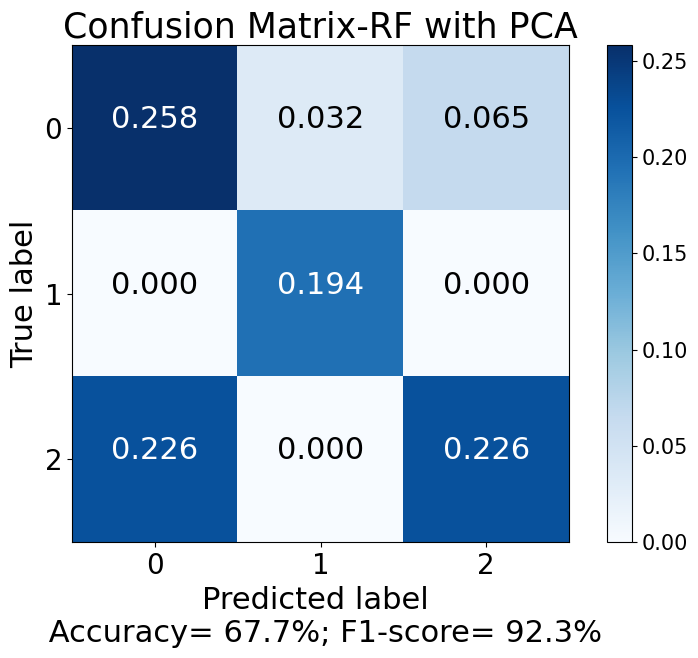

In [ ]:
# Try RF with PCA
rf.fit(X_train_scaled_PC_df,y_train)
PredictLabel_RF_PCA= rf.predict(X_test_scaled_PC_df)
cmRF_PCA = confusion_matrix(y_test, PredictLabel_RF_PCA, normalize='all')

plot_confusion_matrix(cmRF_PCA,Label_classes=['0', '1', '2'],title='Confusion Matrix-RF with PCA')

<ipython-input-87-a80ae926e66c>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled_PC_df,y_train)
<ipython-input-87-a80ae926e66c>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled_PC_df,y_train)
<ipython-input-87-a80ae926e66c>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled_PC_df,y_train)
<ipython-input-87-a80ae926e66c>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled_PC_df,y_train)
<ipython-input-87-a80ae926e66c>:6: DataConversionWarning: A column-vector y was pass

Text(0, 0.5, 'RF accuracies')

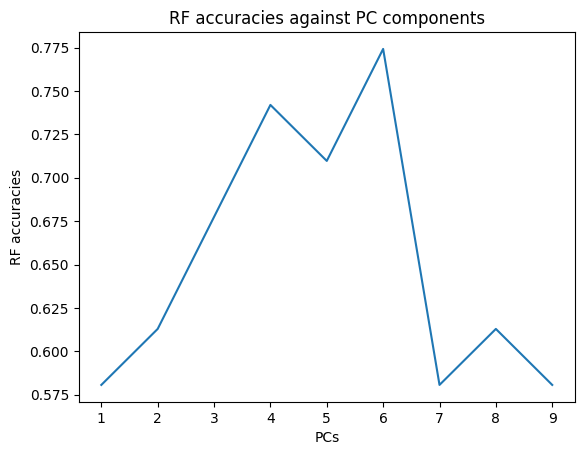

In [ ]:
accuracies = []
for n in range(1, 10):

  X_train_scaled_PC_df, X_test_scaled_PC_df = PCA_transform(X_train_scaled, X_test_scaled, n)

  rf.fit(X_train_scaled_PC_df,y_train)
  PredictLabel_RF_PCA= rf.predict(X_test_scaled_PC_df)

  accuracies.append(accuracy_score(y_test, PredictLabel_RF_PCA))

plt.plot(range(1,10), accuracies)
plt.title("RF accuracies against PC components")
plt.xlabel("PCs")
plt.ylabel("RF accuracies")

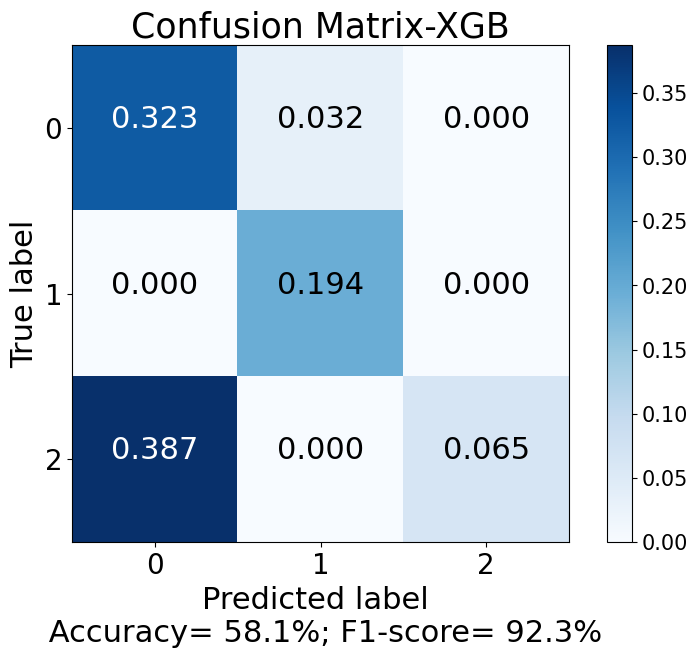

In [ ]:
# Try XGB with PCA
XGB.fit(X_train_scaled_PC_df,y_train)

PredictLabel_XGB_PCA = XGB.predict(X_test_scaled_PC_df)

cmXGB_PCA = confusion_matrix(y_test.ravel(), PredictLabel_XGB_PCA, normalize='all')
plot_confusion_matrix(cmXGB_PCA,Label_classes=['0', '1', '2'],title='Confusion Matrix-XGB')

In [ ]:
from scipy.stats import entropy


# Calculate Shannon entropy
shannon_entropy = entropy(X, base=2)

# Create a dataframe
df_shan = pd.DataFrame({'Shannon_Entropy': [shannon_entropy]})

# Display the dataframe
print(df_shan)

TypeError: ignored

# MATLAB try with Shannon entropy

In [ ]:
double_values_array_pd

,0
0,"[[-59.64016752325922], [-51.79280767040705], [..."
1,"[[1.700575751350959], [5.26036043489714], [11...."
2,"[[38.42035850907248], [41.93719203421008], [45..."
3,"[[13.25933561948333], [20.955944306420164], [2..."
4,"[[17.194687143873036], [22.262271012161733], [..."
...,...
67,"[[10.406102675803657], [7.676324803272685], [3..."
68,"[[-24.227455594401317], [-24.19423019041234], ..."
69,"[[26.30995166883937], [27.724437864311902], [2..."
70,"[[-18.01684927285149], [-21.02290296282209], [..."


In [ ]:
# Calculate Shannon entropy
# Calculate Shannon entropy for each row
Xtrain_entropy_values = np.apply_along_axis(lambda x: entropy(x, base=2), axis=1, arr=X_train)
Xtest_entropy_values = np.apply_along_axis(lambda x: entropy(x, base=2), axis=1, arr=X_test)

X_train_shannon = pd.DataFrame({'Entropy': Xtrain_entropy_values})
X_test_shannon = pd.DataFrame({'Entropy': Xtest_entropy_values})

NameError: ignored

In [ ]:
X_train_shannon

,Entropy
0,3.947650
1,3.879384
2,3.953345
3,3.801109
4,3.770983
...,...
116,3.270110
117,4.139140
118,3.594530
119,4.104214


In [ ]:
X_test_shannon

,Entropy
0,3.085082
1,3.716827
2,4.064494
3,3.818146
4,4.102239
5,4.109546
6,3.957612
7,3.688746
8,3.893754
9,3.609009


<ipython-input-99-93c70432454b>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_shannon,y_train)


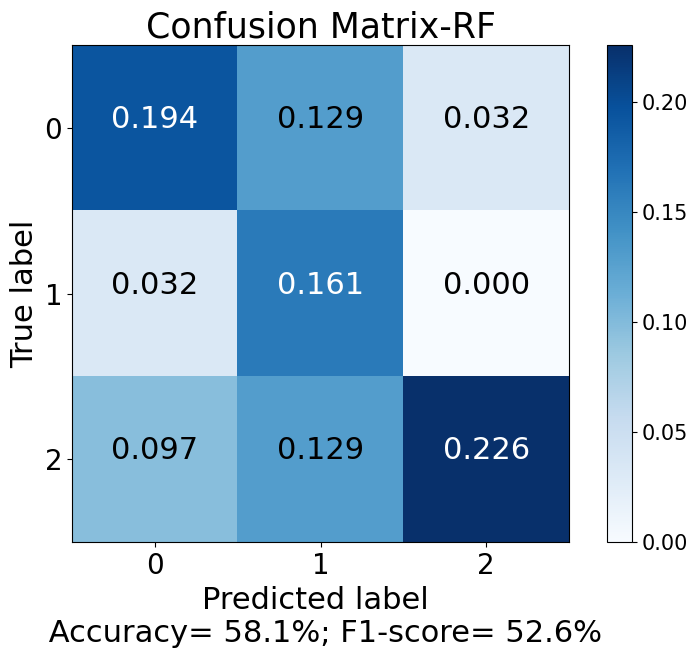

In [ ]:
#RF - new model 1
rf=RandomForestClassifier(n_estimators=1000, random_state = 42)
rf.fit(X_train_shannon,y_train)
PredictLabel_RF= rf.predict(X_test_shannon)
cmRF = confusion_matrix(y_test, PredictLabel_RF, normalize='all')

plot_confusion_matrix(cmRF,Label_classes=['0', '1', '2'],title='Confusion Matrix-RF')


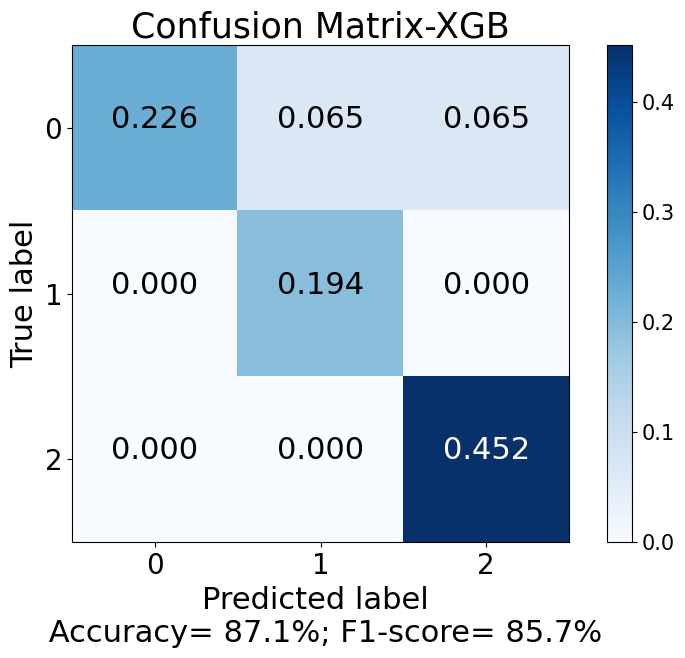

In [ ]:
#XG BOOST - new model 2
XGB = XGBClassifier()
XGB.fit(X_train_scaled, y_train.ravel())

PredictLabel_XGB = XGB.predict(X_test_scaled)

cmXGB = confusion_matrix(y_test.ravel(), PredictLabel_XGB, normalize='all')
plot_confusion_matrix(cmXGB,Label_classes=['0', '1', '2'],title='Confusion Matrix-XGB')

# Trying with MATLAB with DWT data

In [ ]:
# Load data
maddie_contents1 = loadmat('/content/drive/MyDrive/Maddie_Preprocessed_1.mat')
martin_contents1 = loadmat('/content/drive/MyDrive/Martin_Preprocessed_1.mat')
annabel_contents1 = loadmat('/content/drive/MyDrive/Annabel_Preprocessed_1.mat')



# Extract 'trialData' for each person
maddie_data1 = maddie_contents1['trialData']
martin_data1 = martin_contents1['trialData']
annabel_data1 = annabel_contents1['trialData']

df_maddie1 = pd.DataFrame(maddie_data1.flatten())
df_martin1 = pd.DataFrame(martin_data1.flatten())
df_annabel1 = pd.DataFrame(annabel_data1.flatten())

# Concatenate DataFrames along rows
df_combined1 = pd.concat([df_maddie1, df_martin1, df_annabel1], axis=0)


In [ ]:
df_combined1

,Type,CaffIntake,Day,Time,waveMat,HR,EEGSignal,waveMat_DWT
0,[Prebase],[[1]],[2023-11-03],[09-39-33],"[[0.11209141377627405, 0.0356620862135102, 0.0...",[],"[[[[[(array([[-59.64016752],\n [-51.79...","[[0.10866810219246248, 0.029896455332855357, 0..."
1,[NBack],[[1]],[2023-11-03],[10-15-29],"[[1.7630207702351819, 1.2530119850613757, 0.99...",[],"[[[[[(array([[ 1.70057575],\n [ 5.2603...","[[1.058700805522305, 0.25185336725688423, 0.01..."
2,[NBack],[[1]],[2023-11-03],[10-19-06],"[[2.0464026287865176, 1.7411524640678127, 1.78...",[],"[[[[[(array([[38.42035851],\n [41.9371...","[[0.3600872322005434, 0.043911021182278055, 0...."
3,[NBack],[[1]],[2023-11-03],[10-22-40],"[[2.7082310981062543, 2.181162327071589, 2.170...",[],"[[[[[(array([[ 13.25933562],\n [ 20.95...","[[0.3707627886338627, 0.0637489292143244, 0.00..."
4,[Digit],[[1]],[2023-11-03],[10-27-07],"[[3.4785333675282843, 3.1070216482107855, 3.12...",[],"[[[[[(array([[17.19468714],\n [22.2622...","[[0.14789105823250437, 0.02317310419080384, 0...."
...,...,...,...,...,...,...,...,...
3,[NBack],[[0]],[2023-11-14],[11-02-08],"[[1.6231111908776452, 1.452404897394727, 1.442...","[[72.463768115942], [66.07929515418499], [68.8...","[[[[[(array([[-3.32599897],\n [-2.5829...","[[0.1702161717038248, 0.024603495664035246, 0...."
4,[Digit],[[0]],[2023-11-14],[11-07-10],"[[2.064889400718343, 1.9095349287808419, 1.903...","[[72.81553398058239], [73.17073170731705], [79...","[[[[[(array([[-0.27836727],\n [ 3.7989...","[[0.10139652639477502, 0.017162282629191887, 0..."
5,[Digit],[[0]],[2023-11-14],[11-09-54],"[[2.052660140364441, 2.014276797945127, 2.0062...","[[78.9473684210521], [78.534031413613], [77.31...","[[[[[(array([[ 6.77473471],\n [10.0297...","[[0.11504315387517927, 0.02750658238310759, 0...."
6,[Digit],[[0]],[2023-11-14],[11-13-51],"[[2.659908091601192, 2.380890242317055, 2.3269...","[[86.2068965517244], [77.31958762886565], [75....","[[[[[(array([[-35.20264586],\n [-35.45...","[[0.12721822326379978, 0.01892589737670248, 0...."


In [ ]:
X1 = df_combined1['waveMat_DWT']
X1

0    [[0.10866810219246248, 0.029896455332855357, 0...
1    [[1.058700805522305, 0.25185336725688423, 0.01...
2    [[0.3600872322005434, 0.043911021182278055, 0....
3    [[0.3707627886338627, 0.0637489292143244, 0.00...
4    [[0.14789105823250437, 0.02317310419080384, 0....
                           ...                        
3    [[0.1702161717038248, 0.024603495664035246, 0....
4    [[0.10139652639477502, 0.017162282629191887, 0...
5    [[0.11504315387517927, 0.02750658238310759, 0....
6    [[0.12721822326379978, 0.01892589737670248, 0....
7    [[0.013670768678098327, 0.0046284360189167, 0....
Name: waveMat_DWT, Length: 152, dtype: object

In [ ]:
# Flatten each 2D array within the Series
X_flattened1 = X1.apply(lambda x: x.flatten())

# Convert the resulting Series of flattened arrays to a NumPy array
X_flattened_array1 = np.vstack(X_flattened1)

print(X_flattened_array1.shape)

X_flattened_array1

(152, 18)


array([[1.08668102e-01, 2.98964553e-02, 3.10394934e-03, ...,
        2.52372044e-01, 3.89732847e-02, 2.71157648e-03],
       [1.05870081e+00, 2.51853367e-01, 1.21793924e-02, ...,
        8.48200732e-01, 2.04376088e-01, 6.48164909e-02],
       [3.60087232e-01, 4.39110212e-02, 1.85480284e-02, ...,
        3.42333811e-01, 5.02073852e-02, 8.45522070e-02],
       ...,
       [1.15043154e-01, 2.75065824e-02, 5.92833545e-03, ...,
        3.80968103e-02, 2.02795511e-02, 5.65035789e-03],
       [1.27218223e-01, 1.89258974e-02, 4.08674106e-03, ...,
        6.51588243e-02, 1.66375109e-02, 3.82781451e-03],
       [1.36707687e-02, 4.62843602e-03, 1.18790373e-03, ...,
        1.27183764e-02, 2.45279190e-03, 4.30906752e-04]])

In [ ]:
y1 = df_combined1['CaffIntake']
y1

0    [[1]]
1    [[1]]
2    [[1]]
3    [[1]]
4    [[1]]
     ...  
3    [[0]]
4    [[0]]
5    [[0]]
6    [[0]]
7    [[0]]
Name: CaffIntake, Length: 152, dtype: object

In [ ]:
# Flatten each 2D array within the Series
y_flattened1 = y1.apply(lambda y1: y1.flatten())

# Convert the resulting Series of flattened arrays to a NumPy array
y_flattened_array1 = np.vstack(y_flattened1)

y_flattened_array1.shape

(152, 1)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_flattened_array1, y_flattened_array1, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 2. Standardization using Z-score scaling (mean=0, std=1)
scaler_standard = StandardScaler()

X_train_scaled1 = scaler_standard.fit_transform(X_train1)
X_test_scaled1 = scaler_standard.fit_transform(X_test1)

<ipython-input-178-90b534a506b5>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled1,y_train1)


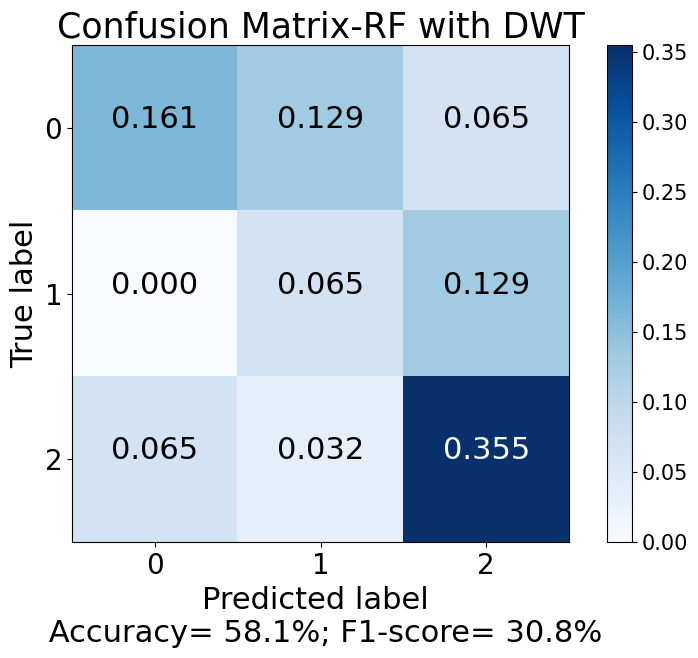

In [ ]:
#RF - new model 1
rf=RandomForestClassifier(n_estimators=1000, random_state = 42)
rf.fit(X_train_scaled1,y_train1)
PredictLabel_RF= rf.predict(X_test_scaled1)
cmRF = confusion_matrix(y_test1, PredictLabel_RF, normalize='all')

plot_confusion_matrix(cmRF,Label_classes=['0', '1', '2'],title='Confusion Matrix-RF with DWT')


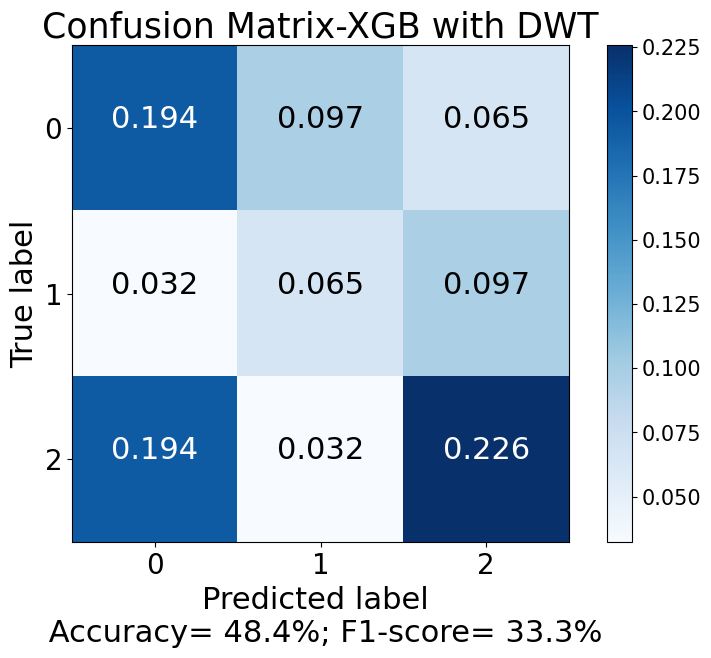

In [ ]:
#XG BOOST - new model 2
XGB = XGBClassifier()
XGB.fit(X_train_scaled1, y_train1.ravel())

PredictLabel_XGB = XGB.predict(X_test_scaled1)

cmXGB = confusion_matrix(y_test1.ravel(), PredictLabel_XGB, normalize='all')
plot_confusion_matrix(cmXGB,Label_classes=['0', '1', '2'],title='Confusion Matrix-XGB with DWT')

In [ ]:
# Load the .mat file
#mat_contents = scipy.io.loadmat('/content/drive/MyDrive/Annabel_Preprocessed.mat')


maddie_contents

# Extract the 'EEG Signal' field
struct_data = maddie_contents['trialData']
struct_data_T = struct_data.T
eeg_signal = struct_data_T['EEGSignal'] #return 72 x 1 array
#eeg_signal = maddie_contents['EEGSignal']

# Initialize an empty list to store the reconstructed data
reconstructed_data_list = []

# Initialize an empty dictionary to store the reconstructed data for each electrode
reconstructed_data_dict = {electrode: [] for electrode in ['LR', 'UR', 'LM', 'UM', 'LL', 'UL']}
i = 0
# Iterate through each struct in 'EEG Signal'
for struct in eeg_signal:
  i += 1
  print(i)
  for electrode in reconstructed_data_dict.keys():
    # Access the 'reconstructed' field within each struct
    reconstructed_data = struct[electrode]['reconstructedSignal']
    reconstructed_data_dict[electrode].append(reconstructed_data)

    # Append the reconstructed data to the list
    reconstructed_data_list.append(reconstructed_data)

reconstructed_data_array = np.array(list(reconstructed_data_dict.values()))

reconstructed_data_array = reconstructed_data_array.T

1


IndexError: ignored

In [ ]:
from scipy.io import loadmat

# Load the .mat file
maddie_contents = loadmat('/content/drive/MyDrive/Maddie_Preprocessed.mat')

# Print the keys to explore the structure
print("Keys in the loaded data:", maddie_contents.keys())

# Access the trialData field
trial_data = maddie_contents['trialData']

# Print the keys in trialData to explore its structure
print("Keys in trialData:", trial_data[0].keys())

# Explore the structure further as needed





Keys in the loaded data: dict_keys(['__header__', '__version__', '__globals__', 'trialData'])


AttributeError: ignored

In [ ]:
eeg_signal_struct.shape

for eeg in eeg_signal_struct:
  print(eeg)

Streaming output truncated to the last 5000 lines.
                         [-3.62465078e+01],
                         [-2.97145071e+01],
                         [ 2.15739337e+01],
                         [-2.11070111e+01],
                         [-4.26491450e+01],
                         [-6.42019728e-01],
                         [-2.53708837e+00],
                         [-1.06531964e+01],
                         [-3.11758540e+01],
                         [ 3.17774079e+01],
                         [ 7.07628793e+00],
                         [-2.04886063e+02],
                         [ 2.00648543e+02],
                         [-3.38371318e+00],
                         [ 1.60361291e+01],
                         [-3.40796335e+01],
                         [ 1.58022020e+01],
                         [ 4.99241320e+00],
                         [ 4.96294588e+01],
                         [-1.67050268e+01],
                         [ 1.90063991e+01],
                         

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
                                                     [-2.71640296e+02],
                                                     [ 5.16655816e+02],
                                                     [-1.10306980e+02],
                                                     [ 1.84172100e+02],
                                                     [ 1.22083239e+03],
                                                     [-5.24163322e+02],
                                                     [ 7.84206274e+02],
                                                     [-9.50015551e+02],
                                                     [ 2.33061047e+02],
                                                     [-2.37850702e+02],
                                                     [-4.99945174e+02],
                                                     [ 1.08765004e+02],
                                                     [ 1.11930657e+03],
             

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
eeg_signal.shape

(72, 1)

In [ ]:
struct_data = maddie_contents['trialData']
struct_data.shape


(1, 72)

In [ ]:
eeg_signal.shape

(1, 1)

In [ ]:
reconstructed_data_array.shape

(1, 74147, 1, 6)

In [ ]:
reshaped_data_array = reconstructed_data_array.reshape(6, 74147)

In [ ]:
reshaped_data_array_pd = pd.DataFrame(reshaped_data_array)
reshaped_data_array_pd

,0,1,2,3,4,5,6,7,8,9,...,74137,74138,74139,74140,74141,74142,74143,74144,74145,74146
0,-202.775026,-202.775026,-202.775026,-202.775026,-202.775026,-202.775026,-181.429110,-181.429110,-181.429110,-181.429110,...,-165.402909,-165.402909,-165.402909,-165.402909,-165.402909,-147.789734,-147.789734,-147.789734,-147.789734,-147.789734
1,-147.789734,-130.064801,-130.064801,-130.064801,-130.064801,-130.064801,-130.064801,-116.162016,-116.162016,-116.162016,...,142.805295,142.805295,142.805295,142.805295,142.805295,142.805295,137.105600,137.105600,137.105600,137.105600
2,137.105600,137.105600,137.195007,137.195007,137.195007,137.195007,137.195007,137.195007,135.876255,135.876255,...,513.307811,510.424436,510.424436,510.424436,510.424436,510.424436,510.424436,508.122207,508.122207,508.122207
3,508.122207,508.122207,508.122207,511.743189,511.743189,511.743189,511.743189,511.743189,511.743189,503.383637,...,865.414842,865.414842,877.373025,877.373025,877.373025,877.373025,877.373025,877.373025,877.261266,877.261266
4,877.261266,877.261266,877.261266,877.261266,874.735519,874.735519,874.735519,874.735519,874.735519,874.735519,...,969.708081,969.708081,969.708081,972.725567,972.725567,972.725567,972.725567,972.725567,972.725567,975.787756
5,975.787756,975.787756,975.787756,975.787756,975.787756,968.344625,968.344625,968.344625,968.344625,968.344625,...,1344.099801,1344.099801,1344.099801,1344.099801,1342.691641,1342.691641,1342.691641,1342.691641,1342.691641,1342.691641


In [ ]:
reconstructed_data_array

array([[[[-202.7750257 , -202.7750257 , -202.7750257 , -202.7750257 ,
          -202.7750257 , -202.7750257 ]],

        [[-181.42910974, -181.42910974, -181.42910974, -181.42910974,
          -181.42910974, -181.42910974]],

        [[-166.90047585, -166.90047585, -166.90047585, -166.90047585,
          -166.90047585, -166.90047585]],

        ...,

        [[1342.37871675, 1342.37871675, 1342.37871675, 1342.37871675,
          1342.37871675, 1342.37871675]],

        [[1344.09980108, 1344.09980108, 1344.09980108, 1344.09980108,
          1344.09980108, 1344.09980108]],

        [[1342.69164117, 1342.69164117, 1342.69164117, 1342.69164117,
          1342.69164117, 1342.69164117]]]])

In [ ]:
def calculate_entropy_for_vectors(data):
    entropies = []
    for vector in data:
        entropy_value = entropy(vector, base=2)
        entropies.append(entropy_value)
    return entropies

# Calculate entropies for each vector
vector_entropies = calculate_entropy_for_vectors(X)

# Create a dataframe with entropies
import pandas as pd

df_shan = pd.DataFrame({'Entropy': vector_entropies})

# Display the dataframe
print(df_shan)

                                              Entropy
0   [2.3041602004453847, 1.8454765634514012, 1.440...
1   [2.015017222303082, 1.6135725071001952, 1.4271...
2   [1.641313355419932, 1.3350614051893066, 1.4508...
3   [1.6994827277259648, 1.4465912563337178, 1.497...
4   [1.5690513252325569, 1.398981248507184, 1.5212...
..                                                ...
67  [1.5420753907462255, 1.4561566794738048, 1.456...
68  [1.5641518786194049, 1.4716616570004246, 1.463...
69  [1.5271182580063363, 1.4751519708305876, 1.477...
70  [1.5782454778085668, 1.5134111143073319, 1.509...
71  [1.9475992471293584, 1.552800690499077, 1.5157...

[72 rows x 1 columns]


(72, 1)

In [ ]:
X_train_flattened = X_train.values.flatten()

In [ ]:
X_train_flattened.shape

(57,)

In [ ]:
X_test_flattened = X_test.values.flatten()
X_test_flattened.shape

(15,)